In [1]:
import tensorflow as tf
import numpy as np
import pickle

import matplotlib.pyplot as plt

2025-10-14 08:22:35.139318: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 08:22:35.181602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%reload_ext autoreload
%autoreload 2

from spin_system import SpinSystem
from spin_system import interactions
# from spin_system import plots

In [14]:
# retry = 1
# while retry < 3:
#     try:
#         lattice_dim = 2
#         sweep_length = int(np.round(5000/retry))
#         lattice_length = 32
#         lattice_replicas = 32
 
#         periodic = ""
#         betas = tf.sort(
#             tf.concat(
#                 [
#                     tf.linspace(0.01, 0.2, 20)
#                 ], 
#                 axis = 0
#             )
#         )

#         interaction_matrix = interactions.z2gauge_interaction_tensor(lattice_length, periodic=periodic)

#         z2_system = SpinSystem(
#             lattice_dim=lattice_dim,
#             lattice_length=lattice_length,
#             lattice_replicas=lattice_replicas,
#             interaction_matrix=interaction_matrix,
#             model="z2_gauge",
#             initial_magnetization=0.0
#         )

#         results = z2_system.multi_temperature_sweep(
#             betas=betas,
#             num_disturb=tf.constant(1, dtype=tf.int32),
#             sweep_length=sweep_length,
#             track_spins = True,
#             track_energy = True,
#             track_magnetization = True,
#             track_plaquette = True,
#             track_overlap = True
#         )

#         # Convert tensors to numpy arrays for saving
#         results_to_save = {k: v.numpy() if isinstance(v, tf.Tensor) else v for k, v in results.items()}

#         # Save the dict
#         with open(f'../data/results_2d_64x64_z2_gauge_periodic_{periodic}_{sweep_length}_steps_v2.pkl', 'wb') as f:
#             pickle.dump(results_to_save, f)

#         break

#     except Exception as e:
#         print(f"Error: {e}")
#         retry += 1

with open(f'../data/results_2d_z2_gauge_periodic_xy_10000_steps.pkl', 'rb') as f:
    results = pickle.load(f)

In [15]:
print(tf.reduce_mean(results['spin_evolution'][-1, -1, 0, :, :, 1])) #(betas, steps, replicas, L, L, xy)
print(tf.reduce_mean(results['spin_evolution'][0, -1, 0, :, :, 1]))

tf.Tensor(-0.00390625, shape=(), dtype=float32)
tf.Tensor(-0.044921875, shape=(), dtype=float32)


In [28]:
loops = []
for i in range(32):
    loops.append(tf.reduce_prod(results['spin_evolution'][-1, -1, 0, :, i, 1]).numpy())

print(np.mean(loops))

-0.125


np.float32(0.0)

In [ ]:
loop_sizes = [i for i in range(1, 21)]

final_spins = results["spin_evolution"][:, -1, :, :, :, :]

wilson_scalars = []

for temp_idx in range(final_spins.shape[0]):
    spin_config = final_spins[temp_idx] 

    loop_values = []
    for loop_size in loop_sizes:
        wl = z2_system.compute_wilson_loop(spin_state=spin_config, loop_size=loop_size)
        avg_wl = tf.reduce_mean(wl)
        loop_values.append(avg_wl)

    wilson_scalars.append(tf.stack(loop_values))

wilson_scalars = tf.stack(wilson_scalars)


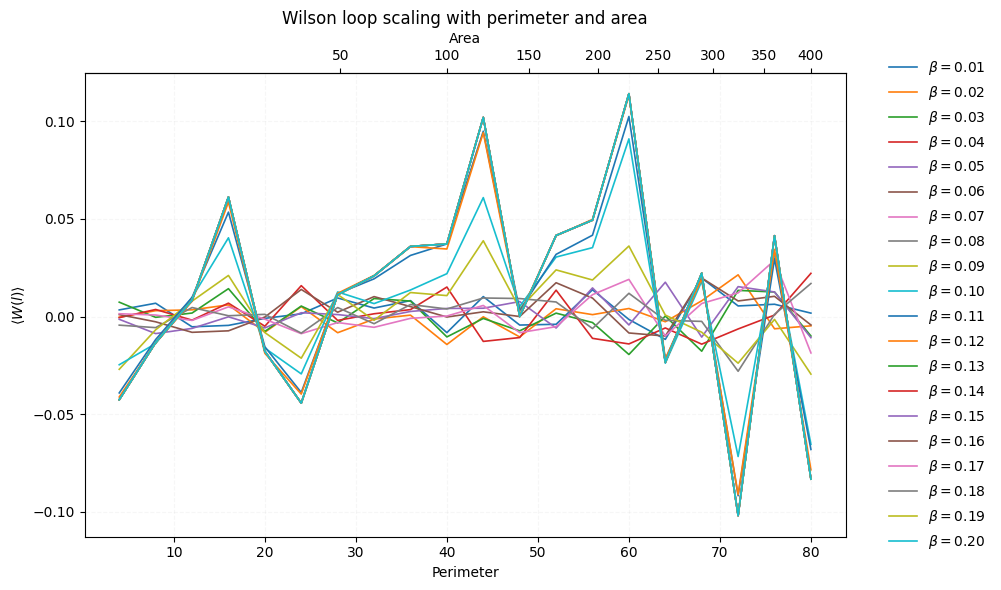

In [ ]:
loop_sizes = np.array(loop_sizes)
perimeters = 4 * loop_sizes
areas = loop_sizes ** 2

plt.figure(figsize=(12, 6))

for i, beta in enumerate(betas):
    plt.plot(
        perimeters,
        wilson_scalars[i].numpy(),
        linewidth=1.2,
        label=fr"$\beta={beta:.2f}$",
    )

plt.xlabel("Perimeter")
plt.ylabel(r"$\langle W(l) \rangle$")
plt.title("Wilson loop scaling with perimeter and area")

plt.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.,
)

ax = plt.gca()
secax = ax.secondary_xaxis(
    'top',
    functions=(lambda p: (p / 4) ** 2, lambda a: 4 * np.sqrt(a))
)
secax.set_xlabel("Area")

plt.grid(True, linestyle="--", alpha=0.1)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


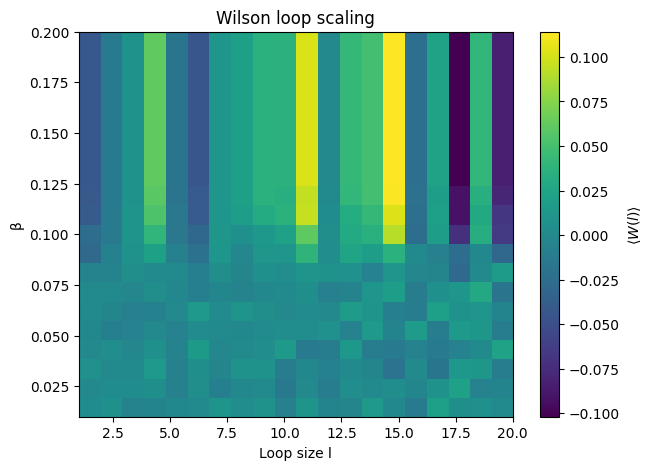

In [ ]:
plt.figure(figsize=(7, 5))
plt.imshow(
    wilson_scalars.numpy(),
    aspect="auto",
    origin="lower",
    extent=[min(loop_sizes), max(loop_sizes), betas[0].numpy(), betas[-1].numpy()],
    cmap="viridis",
)
plt.colorbar(label=r"$\langle W(l) \rangle$")
plt.xlabel("Loop size l")
plt.ylabel(r"β")
plt.title("Wilson loop scaling")
plt.show()
